# Прогнозная модель сервиса подписки

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import itertools

### Дано:
В начале 2020 года был запущен сервис подписки
- Стоимость подписки за 30 дней: 298 руб. с НДС
- В течение года каждый месяц на сервис подписывается 250 новых подписчиков
- Средний срок жизни одного подписчика 9 мес. (т.е. среди пришедших сегодня подписчиков через 9месяцев останется половина активных, а остальные уйдут в отток)

### Нужно подготовить прогноз:
- выручки за отчетный финансовый год (IFRS);
- поступления денежных средств (с НДС) за отчетный финансовый год;
- числа активных подписчиков на конец каждого месяца

### Решение:

Мои допущения:
- что в GrossToNet есть только расходы на банковский процессинг
- 2020 финансовый год с 01.01.2020 по 31.12.2020
- новые пользователи присоединяются 1-го числа каждого месяца, уходят от нас после истечения подписки
- средний отток пользователей выражен в календарных месяцах: если пришел в январе (01.01.2020), то уйдет через 30 дней * 9 месяцев.

#### Вводные данные

In [2]:
price_gross = 298 # руб. с НДС
subscription_days = 30
VAT_rate = 0.20
GtN_bank = 0.015
users_lifetime = 9 # месяцы
users_in = [250 for i in range(12)]
users_cohorts_id = ['cohort_{}'.format(i) for i in range(1, 13)]
start_date = '1/1/2020'
end_date = '31/12/2020'
users_in_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

#### Расчетные функции

In [3]:
def get_net_price(price_gross, VAT_rate):
    '''
     Функция возвращает цену сервиса без НДС
     
     Параметры:
         - price_gross: цена одного периода подписки руб. с НДС
         - VAT_rate: ставка НДС, доля     
    '''
    return round(price_gross / (1 + VAT_rate), 2)

def get_retention_matrix(users_cohorts_id, users_in, users_in_dates, start_date, end_date):
    '''
     Функция возвращает матрицу retention в формате долей (не %) --> dataframe
     
     Параметры:
         - users_cohorts_id: названия когорт пользователей
         - users_in: прогноз притока пользователей, пользователи
         - users_in_dates: прогноз притока пользователей, дата
         - start_date: дата начала финансового года
         - end_date: дата конца финансового года         
    '''      
    # формируем когорты
    df_cohorts_in = pd.DataFrame({'cohort_id': users_cohorts_id, 'cohort_size': users_in}, index=users_in_dates)
    # rретеншн матрица
    df_cohorts_retention = pd.DataFrame(columns=['temp'], index=pd.date_range(start=start_date, end=end_date))
    for i in range(1, 13):
        cohort_in_date = users_in_dates[i-1]
        cohort_out_date = cohort_in_date + datetime.timedelta(days=(users_lifetime * 30))
        col = 'cohort_{}'.format(i)
        df_cohorts_retention.loc[df_cohorts_retention.index<cohort_in_date, col] = 0.0
        df_cohorts_retention.loc[df_cohorts_retention.index>cohort_out_date, col] = 0.5
        df_cohorts_retention.loc[(df_cohorts_retention.index>=cohort_in_date)
                                 & (df_cohorts_retention.index<=cohort_out_date), col] = 1.0   
    df_cohorts_retention = df_cohorts_retention.drop(columns=['temp'])
    return df_cohorts_retention

def get_cohort_size(users_cohorts_id, users_in, users_in_dates):
    '''
     Функция возвращает размеры когорт --> dataframe
     
     Параметры:
         - users_cohorts_id: названия когорт пользователей
         - users_in: прогноз притока пользователей, пользователи
         - users_in_dates: прогноз притока пользователей, дата      
    '''      
    df_cohorts_in = pd.DataFrame({'cohort_id': users_cohorts_id, 'cohort_size': users_in}, index=users_in_dates)
    return df_cohorts_in

def get_active_users(df_cohorts_retention, df_cohort_size):
    '''
     Функция возвращает по дням число активных пользователей --> dataframe
     
     Параметры:
         - df_cohorts_retention: датафрейм с матрицей retention
         - df_cohort_size: датафрейм с размерами когорт  
    '''       
    df_active_users = df_cohorts_retention.copy()
    for i in range(1, 13):
        cohort_name = 'cohort_{}'.format(i)
        cohort_size = df_cohort_size.loc[df_cohort_size['cohort_id'] == cohort_name, 'cohort_size'].values[0]
        df_active_users[cohort_name] = df_cohorts_retention['cohort_{}'.format(i)] * cohort_size
    df_active_users['active_users'] = df_active_users.apply(lambda x: sum(x), 1)
    df_active_users = pd.DataFrame(df_active_users['active_users'])
    return df_active_users

def get_cash_in(df_cohorts_retention, df_cohort_size, users_in_dates, end_date):
    '''
     Функция возвращает по дням прогноз поступления денежных средств (с НДС) --> dataframe
     
     Параметры:
         - df_cohorts_retention: датафрейм с матрицей retention
         - df_cohort_size: датафрейм с размерами когорт  
         - users_in_dates: прогноз притока пользователей, дата
         - end_date: дата конца финансового года                       
    '''  
    
    df_cash_in = df_cohorts_retention.copy()
    for col in df_cash_in.columns:
        df_cash_in[col].values[:] = 0

    for i in range(1, 13):
        cohort_name = 'cohort_{}'.format(i)
        cohort_in_date = users_in_dates[i-1]
        cash_dates = pd.date_range(start=cohort_in_date, end=end_date, freq='30D')
        cohort_size = df_cohort_size.loc[df_cohort_size['cohort_id'] == cohort_name, 'cohort_size'].values[0]
        for date in cash_dates:
            df_cash_in.loc[df_cash_in.index==date, cohort_name] = df_cohorts_retention['cohort_{}'.format(i)] * cohort_size * price_gross
    df_cash_in['cash_in'] = df_cash_in.apply(lambda x: sum(x), axis=1)
    df_cash_in = pd.DataFrame(df_cash_in['cash_in'])
    return df_cash_in

def get_gross_revenue(df_active_users, price_net):
    '''
     Функция возвращает по дням прогноз валовой выручки (без НДС) --> dataframe
     
     Параметры:
         - df_active_users: датафрейм с числом активных пользователей
         - price_net: датафрейм с размерами когорт  
                     
    '''  
    df_gross_revenue = df_active_users.copy()
    df_gross_revenue['gross_revenue'] = df_gross_revenue['active_users'] * price_net / 30
    return df_gross_revenue

def get_monthly_forecast(df_cash_in, df_gross_revenue, start_date, end_date, GtN_bank):
    '''
     Функция возвращает ежемесячный прогноз:
      - количества пользователей, 
      - поступления кэша от подписки с НДС,
      - выручки согласно МСФО,
      - отток (churn rate, %)
    ''' 
    df_daily = df_cash_in.merge(df_gross_revenue, how='left', left_index=True, right_index=True)
    month_beg = pd.date_range(start=start_date, end=end_date, freq='MS')
    month_end = pd.date_range(start=start_date, end=end_date, freq='M')
    df_daily['active_users_beg'] = np.where(df_daily.index.isin(month_beg), df_daily['active_users'], 0)
    df_daily['active_users_end'] = np.where(df_daily.index.isin(month_end), df_daily['active_users'], 0)
    df_daily['month'] = df_daily.index.month

    df_monthly = df_daily.groupby('month')[['active_users_beg', 'active_users_end', 'cash_in', 'gross_revenue']].sum()
    df_monthly['cash_in'] = np.round(df_monthly['cash_in'] / 1000, 1)
    df_monthly['gross_revenue'] = np.round(df_monthly['gross_revenue'] / 1000, 1)
    df_monthly['active_users_beg'] = np.round(df_monthly['active_users_beg'], 0).astype(int)
    df_monthly['active_users_end'] = np.round(df_monthly['active_users_end'], 0).astype(int)

    df_monthly['_banks'] = np.round(- df_monthly['gross_revenue'] * GtN_bank, 1)
    df_monthly['net_revenue'] = df_monthly['gross_revenue'] + df_monthly['_banks']
    df_monthly['churn_rate'] = np.round(
        (df_monthly['active_users_beg'] - df_monthly['active_users_end']) / (df_monthly['active_users_beg']) * 100, 1)
    return df_monthly

#### Расчет модели

In [4]:
# net-price
price_net = get_net_price(price_gross, VAT_rate)
# матрица с retention
df_cohorts_retention = get_retention_matrix(users_cohorts_id, users_in, users_in_dates, start_date, end_date)
# размеры когорты
df_cohort_size = get_cohort_size(users_cohorts_id, users_in, users_in_dates)
# число активных пользователей по дням
df_active_users = get_active_users(df_cohorts_retention, df_cohort_size)
# прогноз поступления денежных средств по дням
df_cash_in = get_cash_in(df_cohorts_retention, df_cohort_size, users_in_dates, end_date)
# прогноз валовой выручки по дням
df_gross_revenue = get_gross_revenue(df_active_users, price_net)
# помесячный прогноз 
df_monthly = get_monthly_forecast(df_cash_in, df_gross_revenue, start_date, end_date, GtN_bank)

# форматирую и вывожу результат
table = df_monthly.transpose()
table['FY'] = table.apply(lambda x: sum(x), axis=1)
table.loc['churn_rate', 'FY'] = table.loc['churn_rate', 12]
table

month,1,2,3,4,5,6,7,8,9,10,11,12,FY
active_users_beg,250.0,500.0,750.0,1000.0,1250.0,1500.0,1750.0,2000.0,2250.0,2375.0,2500.0,2625.0,18750.0
active_users_end,250.0,500.0,750.0,1000.0,1250.0,1500.0,1750.0,2000.0,2125.0,2250.0,2375.0,2500.0,18250.0
cash_in,149.0,74.5,372.5,298.0,596.0,447.0,670.5,670.5,670.5,856.8,745.0,931.2,6481.5
gross_revenue,64.2,120.0,192.5,248.3,320.8,372.5,449.1,513.2,555.6,606.3,616.7,669.5,4728.7
_banks,-1.0,-1.8,-2.9,-3.7,-4.8,-5.6,-6.7,-7.7,-8.3,-9.1,-9.3,-10.0,-70.9
net_revenue,63.2,118.2,189.6,244.6,316.0,366.9,442.4,505.5,547.3,597.2,607.4,659.5,4657.8
churn_rate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.6,5.3,5.0,4.8,4.8


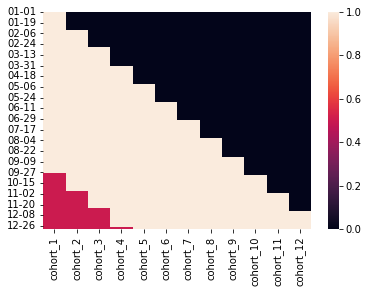

In [5]:
df_cohorts_retention.index = df_cohorts_retention.index.strftime('%m-%d')
sns.heatmap(df_cohorts_retention);